In [59]:
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

n=50

true_beta = np.transpose(stats.norm.rvs(loc=0,scale=1,size=2))
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = np.transpose(np.array([np.ones(n),stats.norm.rvs(loc=0,scale=1,size=n)]))
y = np.random.normal(x.dot(true_beta), np.sqrt(1/true_phi))


beta0 = stats.norm.rvs(loc=0,scale=1,size=2)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

#Set hyperparameters
a = 3.0
b= 2.0

print(true_beta,true_phi)
print(theta0)

[-0.66657204  1.98010621] [ 2.16585499]
[ 0.60209728 -1.18600689  1.50237352]


In [60]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
def FindReasonableEpsilon(y,x,theta):
    eps = 1
    r = stats.norm.rvs(size=3)
    theta_prime,r_prime = leapfrog(y,x,theta,r,eps)
    frac = np.exp(log_joint(y,x,theta_prime)-log_joint(y,x,theta)-(1/2)*r_prime.dot(r_prime)+(1/2)*r.dot(r))
    if(frac>0.5):
        a = 1
    else:
        a = -1
    while(pow(frac,a)>pow(2,-a)):
        eps = eps*pow(2,a)
        theta_prime,r_prime = leapfrog(y,x,theta,r,eps)
    return eps    

In [77]:
def leapfrog(y,x,theta, r, eps):
    n = y.shape[0]
    gradients = np.hstack([theta[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta[0:2]))-.01*theta[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta[0:2]))).dot(y-x.dot(theta[0:2]))])
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    gradients = np.hstack([theta_upd[2]*(np.transpose(y).dot(x)-np.transpose(x).dot(x).dot(theta_upd[0:2]))-.01*theta_upd[0:2],(.5*n+a-1)/theta[2]-b-0.5*np.transpose((y-x.dot(theta_upd[0:2]))).dot(y-x.dot(theta_upd[0:2]))])
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [78]:
def log_joint(y, x, theta): 
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=x.dot(theta[0:2]), scale=1/np.sqrt(theta[2])))+norm.logpdf(theta[0],loc=0,scale=1/np.sqrt(.01))+norm.logpdf(theta[1],loc=0,scale=1/np.sqrt(.01)) +gamma.logpdf(theta[2], a, scale=1/b) 

In [79]:
def BuildTree(y,x,theta, r, u, v, j, eps, theta_0, r_0):
    triangle_max = 10000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(y,x,theta,r,v*eps)
        if(u <= np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            n_prime = 1
        else:
            n_prime = 0
        if(u < np.exp(triangle_max+log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime)) ):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,theta_prime,n_prime,s_prime,min(1,np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime)-
                                                                                               log_joint(y,x,theta_0)+(1/2)*r_0.dot(r_0))),1    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime,alpha_prime,n_aprime = BuildTree(y,x,theta,r,u,v,j-1,eps,theta_0,r_0)
        if(s_prime==1):
            if(v == -1):
                theta_minus,r_minus,dash1,dash2,theta_primep,n_primep,s_primep,alpha_primep,n_aprimep = BuildTree(y,x,theta_minus,r_minus,u,v,j-1,eps,theta_0,r_0)
            else:
                dash1,dash2,theta_plus,r_plus,theta_primep,n_primep,s_primep,alpha_primep,n_aprimep = BuildTree(y,x,theta_plus,r_plus,u,v,j-1,eps,theta_0,r_0)   
            p = np.exp(np.log(n_primep)-np.log(n_prime+n_primep))
            unif = np.random.uniform()
            if(p>u):
                theta_prime = theta_primep
            alpha_prime = alpha_prime+alpha_primep
            n_aprime = n_aprime+n_aprimep
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):  
                s_prime = s_primep  
            else:
                s_prime = 0  
            n_prime = n_prime+n_primep
    return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_aprime

In [80]:
def NUTS_Dual_Average(y,x,theta0,delta,M,M_adapt):
    theta_m = np.zeros((M,3))
    theta_m[0:1,:] = theta0
    eps = np.zeros((M,1))
    eps[0] = FindReasonableEpsilon(y,x,theta_m[0,:])
    mu = np.log(10*eps[0])
    eps_bar = np.zeros((M,1))
    eps_bar[0] = 1
    H_bar = np.zeros((M,1))
    H_bar[0] = 0
    gamma = 0.05
    t0 = 10
    kappa = 0.75
    for m in range(1,M):
        print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=3)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        theta_m[m,:] = theta_m[m-1,:]
        n = 1
        s = 1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime,alpha,n_alpha = BuildTree(y,x,theta_minus,r_minus,u,v_j,j,eps[m-1],theta_m[m-1],r0)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime,alpha,n_alpha = BuildTree(y,x,theta_plus,r_plus,u,v_j,j,eps[m-1],theta_m[m-1],r0)
            if(s_prime == 1):
                p = min(1,np.exp(np.log(n_prime)-np.log(n)))
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
            j = j+1    
        if(m <= M_adapt):
            H_bar[m] = (1-1/(m+t0))*H_bar[m-1]+(1/(m+t0))*(delta-(alpha/n_alpha))
            eps[m] = np.exp(mu-(pow(mu,0.5)/gamma)*H_bar[m])
            eps_bar[m] = np.exp(pow(m,-kappa)*np.log(eps[m])+(1-pow(m,-kappa))*np.log(eps_bar[m-1]))
        else:
            eps[m] = eps_bar[M_adapt]
    return(theta_m)

In [81]:
M = 1000
delta=0.6 #between 0 and 1
M_adapt = 50

In [82]:
%%time
results = NUTS_Dual_Average(y,x,theta0,delta,M,M_adapt)
print("truth", (true_beta, true_phi))
beta0_found = np.mean(results[round(4*M/5):(M-1),0])
beta1_found = np.mean(results[round(4*M/5):(M-1),1])
phi_found = np.mean(results[round(4*M/5):(M-1),2])
print("Mean after burn in we find",beta0_found,beta1_found ,phi_found)


[-102.21747445  269.78001409 -334.87325294]
[ -392080.96848502  1240124.51472112  -549622.52059392]
M:  1  Theta:  [ 0.60209728 -1.18600689  1.50237352]
[-102.21747445  269.78001409 -334.87325294]
[ -395313.9766507   1252573.97013836  -555166.64668484]
M:  2  Theta:  [ 0.60209728 -1.18600689  1.50237352]
[-102.21747445  269.78001409 -334.87325294]
[ -3.39336635e+11   1.06881933e+12  -4.82370156e+11]
M:  3  Theta:  [ 0.60209728 -1.18600689  1.50237352]
[-102.21747445  269.78001409 -334.87325294]
[ -1.34248877e+13   4.23157075e+13  -1.90945736e+13]
M:  4  Theta:  [ 0.60209728 -1.18600689  1.50237352]
[-102.21747445  269.78001409 -334.87325294]
[ -3.01796632e+14   9.51284842e+14  -4.29215977e+14]
M:  5  Theta:  [ 0.60209728 -1.18600689  1.50237352]
[-102.21747445  269.78001409 -334.87325294]
[ -4.34930947e+15   1.37078942e+16  -6.18562787e+15]
M:  6  Theta:  [ 0.60209728 -1.18600689  1.50237352]
[-102.21747445  269.78001409 -334.87325294]
[ -4.39197137e+16   1.38415380e+17  -6.24587244e+1

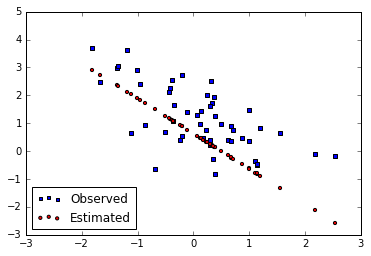

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
betas_found = np.hstack([beta0_found,beta1_found])
y_sim = stats.norm.rvs(loc=x.dot(betas_found),scale=1/np.sqrt(phi_found))
#y_sim = stats.norm.rvs(loc=x*beta_found,scale=phi_found)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x[:,1], y, s=10, c='b', marker="s", label='Observed')
ax1.scatter(x[:,1], y_sim, s=10, c='r', marker="o", label='Estimated')
plt.legend(loc='lower left');
plt.show()

In [ ]:
1/np.sqrt(.05)